## Final Project Submission

Please fill out:
* Student name: Nick Timpano 
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Jeff 
* Blog post URL: 

For this EDA of movie data, I sought to answer 4 basic questions: 
1. What genre(s) should be recommended? 
2. What budget should be used? 
3. Who are the actors,actresses and directors to recruit? 
4. When should the movie be released? 

Several sources of data were explored, and I determined that TMDB was the best choice for movie data and IMDB was great for information on people. I used the TMDB dataset provided, and added data about genres and IMDB ids using the TMDB api. The script I used in included in my github. 

Lastly, I thought it prudent to adjust dollars for inflation. As opposed to only including data from the past few years, I thought this would allow me to include older movies as part of the analysis without skewing the results. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import time
from datetime import datetime

tmdb_movies_updated =  pd.read_csv('zippedData/tmdb/tmdb_movies_updated.csv',index_col=0)  #/tmdb_scrape.py
tmdb_movies_2019 = pd.read_csv('zippedData/tmdb/tmdb_movies_2019.csv',index_col=0)  #/tmdb_scrape_02.py
tmdb_movies_2020 = pd.read_csv('zippedData/tmdb/tmdb_movies_2020.csv',index_col=0)  #/tmdb_scrape_02.py
tmdb_genres = pd.read_csv('zippedData/tmdb/tmdb_genres.csv', index_col=0) #tmdb_scraping.ipynb

title_basics = pd.read_csv('zippedData/imdb/title.basics.csv')
title_ratings = pd.read_csv('zippedData/imdb/updated/title_ratings.tsv',sep='\t') #https://datasets.imdbws.com/
imdb_people = pd.read_csv('zippedData/imdb/name.basics.csv')
title_principals = pd.read_csv('zippedData/imdb/title.principals.csv')

movie_budgets = pd.read_csv('zippedData/budgets/tn.movie_budgets.csv')

inflation_rates = pd.read_csv('avg_inflation_rates.csv')
#https://www.usinflationcalculator.com/inflation/historical-inflation-rates/


In [2]:
frames = [tmdb_movies_updated,tmdb_movies_2019,tmdb_movies_2020]
tmdb_movies = pd.concat(frames)

In [3]:
len(tmdb_genres)

19

### inflation rates dictionary 

In [4]:
# create inflation rates dictionary 
ir_data = inflation_rates.to_dict('split')
ir = ir_data['data']
ir_dict = {item[0]:item[1] for item in ir}

### imdb movies cleaning 

In [5]:
title_ratings.rename(columns={'averageRating':'avg_rating'},inplace=True)

### tmdb_movies cleaning 

In [6]:
# convert the genre ids from strings into lists of numbers 
def convert_list(lst):
    try:
        lst1 = lst.strip('][').split(', ')
        return [int(x) for x in lst1]
    except:
        return 0
    
# convert the genre columns to numbers  
tmdb_movies['genre_ids'] = tmdb_movies.genre_ids.apply(lambda x: convert_list(x))

#convert the release date column to datetime 
tmdb_movies.release_date = tmdb_movies.release_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) 

# drop duplicates 
tmdb_movies = tmdb_movies.drop_duplicates(subset=['id'])

# add profits column 
tmdb_movies['profits'] = tmdb_movies['revenue'] - tmdb_movies['budget']

# add roi column 
tmdb_movies['roi'] = tmdb_movies['revenue']/tmdb_movies['budget']
tmdb_movies['roi'] = tmdb_movies['roi'].round(1)

In [7]:
# Method to adjust all to 2020 dollars 
# loop through each row, taking the revenue and budget and calculating new numbers  
def adjust_inflation(original_df):
    df = original_df.copy()
    for index, row in df.iterrows():
        year = row['release_date'].year
        current_revenue = row['revenue']
        current_budget = row['budget']
        revenues = []
        budgets = []
        # loop through all years up until 2020 
        for curr_year in range(year, 2021, 1):
            #print(curr_year)
            inflation_rate = ir_dict[curr_year]
            new_revenue = (current_revenue *  float(inflation_rate/100)) + current_revenue
            current_revenue = new_revenue 
            new_budget = (current_budget *  float(inflation_rate/100)) + current_budget 
            current_budget = new_budget 
        #df.at[i, 'ifor'] = x
        df.at[index,'revenue'] = current_revenue 
        df.at[index,'budget'] = current_budget 
        revenues.append(current_revenue)
        budgets.append(current_budget) 
    # add profits column 
    df['profits'] = df['revenue'] - df['budget']

    # add roi column 
    df['roi'] = df['revenue']/df['budget']
    df['roi'] = df['roi'].round(1)
    return df
    

# Question 1: Which genres should be considered? 
*Which genres will generate the best revenue and returns, and which are most popular?*

In [8]:
# drop rows with no genres listed  
q1 = tmdb_movies[tmdb_movies['genre_ids'] != 0]

# drop rows with budgets lower than 1000 
q1 = q1[q1['budget'] > 1000]

# drop rows with no revenue 
q1 = q1[q1['revenue'] > 0]


## (1a) What genres generate the highest revenue and returns? 

In [9]:
# return revenue for one genre category in billions 
def total_revenue(df, genre):         
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] # get a dataframe of just that genre 
    return round((sub_df['revenue'].sum()/1000000000),2)

def median_revenue(df, genre):         
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] # get a dataframe of just that genre 
    return round((sub_df['revenue'].median()/1000000),2)

def mean_revenue(df, genre):         
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] # get a dataframe of just that genre 
    return round((sub_df['revenue'].mean()/1000000),2)

# return profits for one genre category in billions 
def calculate_profits(df, genre):
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] 
    return round((sub_df['profits'].sum()/1000000000),2)

# return number of movies for one genre category 
def calculate_num_movies(df, genre):         
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)]
    return len(sub_df) 

def median_roi(df,genre):
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] 
    sub_df = sub_df[sub_df.budget > 1000] # for outliers/incorrect information 
    return sub_df['roi'].median() 

def mean_roi(df,genre):
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] 
    sub_df = sub_df[sub_df.budget > 1000] # for outliers/incorrect information 
    return sub_df['roi'].mean() 

def mean_budget(df, genre):
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] 
    sub_df = sub_df[sub_df.budget > 1000] # for outliers/incorrect information 
    return round((sub_df['budget'].mean()/1000000),2)     

def median_budget(df, genre):
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] 
    sub_df = sub_df[sub_df.budget > 1000] # for outliers/incorrect information 
    return round((sub_df['budget'].median()/1000000),2)  

# return revenue and profits by genres for all movies made since start_year  
def numbers_by_genre_df(df):
    output = tmdb_genres.copy() 
    output['total_revenue_billions'] = tmdb_genres.id.apply(lambda x: total_revenue(df, x))
    output['total_profits_billions'] = tmdb_genres.id.apply(lambda x: calculate_profits(df, x))
    output['num_movies'] = tmdb_genres.id.apply(lambda x: calculate_num_movies(df, x))
    output['median_roi'] = tmdb_genres.id.apply(lambda x: median_roi(df, x))
    output['mean_roi'] = tmdb_genres.id.apply(lambda x: mean_roi(df, x))
    output['mean_budget_millions'] = tmdb_genres.id.apply(lambda x: mean_budget(df,x))
    output['median_budget_millions'] = tmdb_genres.id.apply(lambda x: median_budget(df,x))
    output['mean_revenue_millions'] = tmdb_genres.id.apply(lambda x: mean_revenue(df,x))
    output['median_revenue_millions'] = tmdb_genres.id.apply(lambda x: median_revenue(df, x))
    output = output.sort_values(by="mean_revenue_millions", ascending=False)
    output = output[['genre','num_movies','median_budget_millions','mean_budget_millions',
                     'mean_revenue_millions','median_revenue_millions','median_roi','mean_roi']]
    return output

q1 = adjust_inflation(q1) # adjust the numbers for inflation 
# get stats by genre 
numbers_by_genre = numbers_by_genre_df(q1)
numbers_by_genre


,genre,num_movies,median_budget_millions,mean_budget_millions,mean_revenue_millions,median_revenue_millions,median_roi,mean_roi
1,Adventure,432,88.74,103.43,356.72,177.51,2.30,3.672685
14,Science Fiction,269,62.47,89.59,317.77,139.97,2.30,3.814126
8,Fantasy,271,67.58,89.48,299.60,135.60,2.30,3.722509
2,Animation,181,66.58,80.17,292.06,141.51,2.60,4.225414
7,Family,266,61.36,78.67,269.03,135.78,2.40,3.298120
0,Action,672,42.50,72.55,231.44,80.84,2.10,3.168304
3,Comedy,792,22.17,37.75,124.71,48.34,2.40,3.858712
18,Western,23,44.39,65.03,120.99,46.68,1.50,1.769565
17,War,88,21.87,37.83,105.35,18.49,1.15,2.267045
16,Thriller,642,18.04,35.36,103.04,35.82,1.70,4.683956


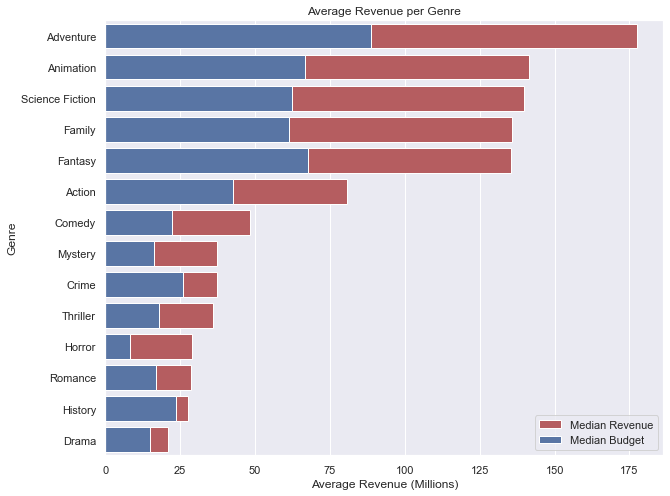

In [10]:
sns.set_theme(style="darkgrid")
sns.set_context("notebook")

# plot the average revenue of movies for each genre 

plt.figure(figsize=(10,8))
# use only genres with at least 100 movies 
data=numbers_by_genre[numbers_by_genre.num_movies > 100].\
    sort_values(by='median_revenue_millions', ascending=False) 
sns.barplot(x=data['median_revenue_millions'],
                y=data['genre'],
                color='r',label='Median Revenue')
bottom_plot = sns.barplot(x=data['median_budget_millions'],
                y=data['genre'],
                color='b',label ='Median Budget')
plt.xlabel('Average Revenue (Millions)')
plt.ylabel('Genre')
plt.title('Average Revenue per Genre')
plt.legend()

***
Adventure movies maximize revenue, followed by fantasy and sci-fi. 
***

In [ ]:
plt.clf()

# plot the average ROI by genre 
plt.figure(figsize=(10,8))
data=numbers_by_genre.iloc[:-2].sort_values(by='median_roi', ascending=False)
sns.barplot(x=data['median_roi'],
                y=data['genre'], 
                color='b')
plt.xlabel('Average (Median) ROI Multiple')
plt.ylabel('Genre')
plt.title('Average ROI Multiple per Genre')

***
**Horror** movies actually seem to potentially generate the best returns. To maximize revenue and returns **Fantasy** movies are a good bet, as well as **Science Fiction and Adventure**. 
***

## (1b) What genre combinations generate the best revenue and returns? 

In [12]:
# create a list of all the combinations of genres 
genre_list = list(tmdb_genres['id'])
print(genre_list)
print(genre_list[1:]) #[28, 12, 16, 35, 80, 99, 18, 10751, 14, 36, 27, 10402, 9648, 10749, 878, 10770, 53, 10752, 37]
# in reverse 
print(genre_list[1:][::-1]) #[37, 10752, 53, 10770, 878, 10749, 9648, 10402, 27, 36, 14, 10751, 18, 99, 80, 35, 16, 12]

combinations = []
# loop by index  
for i1 in range(len(genre_list)):
    # start from the current index + 1 and go to the end 
     for i2 in range(i1+1,len(genre_list)):
        # add list of outer loop item and all inner loop items 
        combinations.append([genre_list[i1],genre_list[i2]])
len(combinations)  # 171        

[28, 12, 16, 35, 80, 99, 18, 10751, 14, 36, 27, 10402, 9648, 10749, 878, 10770, 53, 10752, 37]
[12, 16, 35, 80, 99, 18, 10751, 14, 36, 27, 10402, 9648, 10749, 878, 10770, 53, 10752, 37]
[37, 10752, 53, 10770, 878, 10749, 9648, 10402, 27, 36, 14, 10751, 18, 99, 80, 35, 16, 12]


171

In [13]:
# sort each combination of genre by profits 
# create a dataframe from the combinations list 

def calculate_profits_combo(df, combination):
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combination))] # get dataframe of all movies with the combination 
    return round((sub_df['profits'].sum()/1000000000),2)

def calculate_num_movies_combo(df, combination):         
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combination))]
    return len(sub_df) 

def total_revenue_combo(df, combination):         
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combination))]
    return round((sub_df['revenue'].sum()/1000000000),2)

def mean_revenue_combo(df, combination):         
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combination))]
    return round((sub_df['revenue'].mean()/1000000),2)

def median_revenue_combo(df, combination):         
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combination))]
    return round((sub_df['revenue'].median()/1000000),2)

def mean_roi_combo(df, combination):
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combination))]
    sub_df = sub_df[sub_df.budget > 1000]
    return sub_df['roi'].mean()  

def median_roi_combo(df, combination):
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combination))]
    sub_df = sub_df[sub_df.budget > 1000]
    return sub_df['roi'].median()  

def mean_budget_combo(df, combination):
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combination))]
    sub_df = sub_df[sub_df.budget > 1000]
    return round((sub_df['budget'].mean()/1000000),2)

def median_budget_combo(df, combination):
    sub_df = df[df.genre_ids.apply(lambda x: all(item in x for item in combination))]
    sub_df = sub_df[sub_df.budget > 1000]
    return round((sub_df['budget'].median()/1000000),2)

def id_to_genre(combination):
    output = []
    for item in combination:
        output.append(tmdb_genres[tmdb_genres.id == item]['genre'].values[0])
    return output 

def numbers_by_combo_df(df):
    movies = df.copy()
    output = pd.DataFrame({0:combinations})
    output.columns = ['combinations']
    output['total_revenue_billions'] = output.combinations.apply(lambda x: total_revenue_combo(movies, x))
    output['total_profits_billions'] = output.combinations.apply(lambda x: calculate_profits_combo(movies, x))
    output['num_movies'] = output.combinations.apply(lambda x: calculate_num_movies_combo(movies, x))
    output['mean_roi'] = output.combinations.apply(lambda x: mean_roi_combo(movies, x))
    output['median_roi'] = output.combinations.apply(lambda x: median_roi_combo(movies, x))
    output['mean_revenue_millions'] = output.combinations.apply(lambda x: mean_revenue_combo(movies, x))
    output['median_revenue_millions'] = output.combinations.apply(lambda x: median_revenue_combo(movies, x))
    output['mean_budget_millions'] = output.combinations.apply(lambda x: mean_budget_combo(movies, x))
    output['median_budget_millions'] = output.combinations.apply(lambda x: median_budget_combo(movies, x))
    output['genre_combo'] = output.combinations.apply(lambda x: id_to_genre(x))
    output = output.sort_values(by="median_revenue_millions", ascending=False)
    output = output[['genre_combo','num_movies','mean_budget_millions','median_budget_millions',
                     'mean_revenue_millions','median_revenue_millions','mean_roi','median_roi']]
    return output

numbers_by_combo = numbers_by_combo_df(q1) 
numbers_by_combo = numbers_by_combo[numbers_by_combo.num_movies > 10] # only include results where more than 10 movies were counted 

In [14]:
numbers_by_combo

,genre_combo,num_movies,mean_budget_millions,median_budget_millions,mean_revenue_millions,median_revenue_millions,mean_roi,median_roi
30,"[Adventure, Science Fiction]",113,142.90,146.42,555.94,374.76,4.461062,2.90
0,"[Action, Adventure]",219,128.78,123.89,455.25,289.74,3.651142,2.50
13,"[Action, Science Fiction]",165,119.84,122.37,431.88,268.00,4.013333,2.50
7,"[Action, Fantasy]",99,129.12,126.59,442.46,254.94,4.190909,2.90
24,"[Adventure, Fantasy]",145,125.35,126.59,440.46,238.24,4.105517,2.70
...,...,...,...,...,...,...,...,...
133,"[History, War]",31,35.27,21.70,91.29,19.15,2.848387,1.00
25,"[Adventure, History]",14,44.83,28.97,39.33,17.64,0.728571,0.90
103,"[Drama, War]",72,36.10,21.62,95.45,17.39,2.265278,1.20
156,"[Romance, Science Fiction]",13,38.95,32.31,80.03,17.08,2.346154,2.10


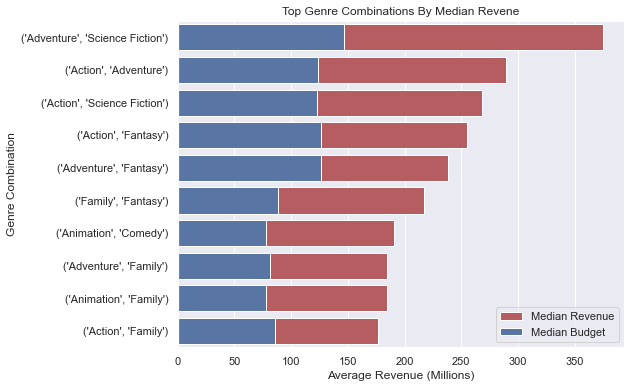

In [15]:
# Plot AVG revenue per genre combination
# convert lists to tuples so seaborn can process 
data = numbers_by_combo.sort_values(by='median_revenue_millions', ascending=False)[:10]
data.genre_combo = data.genre_combo.apply(lambda x: tuple(x))
plt.figure(figsize=(8,6))
sns.barplot(x=data['median_revenue_millions'],
                y=data['genre_combo'], 
                color='r',label='Median Revenue')
sns.barplot(x=data['median_budget_millions'],
                y=data['genre_combo'], 
                color='b',label='Median Budget')
plt.xlabel('Average Revenue (Millions)')
plt.ylabel('Genre Combination')
plt.title('Top Genre Combinations By Median Revene')
plt.legend()

***
Sci-Fi / Adventure movies seem to be a top combination! 
***

Text(0.5, 1.0, 'Top Genre Combinations by Median ROI')

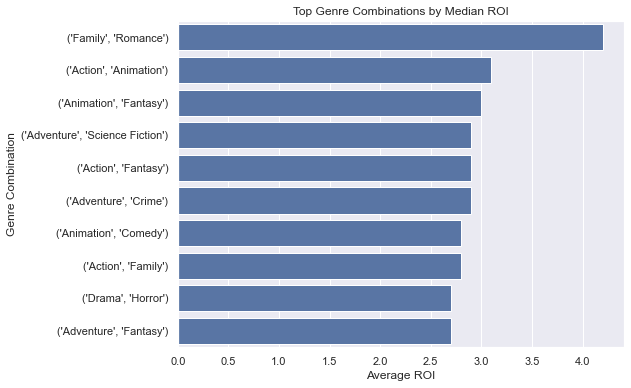

In [16]:
# Plot AVG ROI per genre combination 

# convert lists to tuples so seaborn can process 
df = numbers_by_combo.sort_values(by='median_roi', ascending=False)[:10]
df.genre_combo = df.genre_combo.apply(lambda x: tuple(x))

plt.figure(figsize=(8,6))
sns.barplot(x='median_roi',
                y='genre_combo',
                data=df, 
                color='b')
plt.xlabel('Average ROI')
plt.ylabel('Genre Combination')
plt.title('Top Genre Combinations by Median ROI')

***
Looking at returns, **Adventure + Science Fiction** is in the number 4 spot, which makes it a strong choice along this dimension as well. |
***

# Question 2: What budget should be used?

In [17]:
# drop rows with no genres listed  
q2 = tmdb_movies[tmdb_movies['genre_ids'] != 0]

# drop rows with budgets lower than 10000000 
q2 = q2[q2['budget'] >= 10000000] 

q2 = adjust_inflation(q2) # adjust the numbers for inflation 
q2 = q2[q2.roi != 0] # drop rows with no ROI 


In [18]:
q2[q2.title.apply(lambda x: 'Endgame' in x)]

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,revenue,budget,runtime,imdb_id,profits,roi
2,"[12, 878, 28]",299534,en,Avengers: Endgame,418.334,2019-04-24,Avengers: Endgame,8.3,17392,2.882339e+09,366756896.0,181,tt4154796,2.515582e+09,7.9


## (2a) What's the average budget for the top 25 most successful high budget movies? 
*High budget movies are movies with budgets of $50MM USD and up. Successful movies generate the best returns.* 

In [19]:
# high budget movies are >= $50MM  
high_budget = q2[q2.budget >= 50000000]
high_budget = high_budget.sort_values(by='roi',ascending=False)

# get the top 25 high budget movies, by returns 
top_25 = high_budget.sort_values(by='roi',ascending=False).head(25).reset_index() 
top_25['budget'] = round(top_25['budget'] / 1000000, 2) # divide all budgets by 1MM 
top_25 = top_25.sort_values(by='budget',ascending=False).reset_index()
print(top_25.budget.mean())
print(top_25.budget.median())


109.4896
85.6


| The mean budget for the top 25 most successful movies is $109.5 MM USD. 

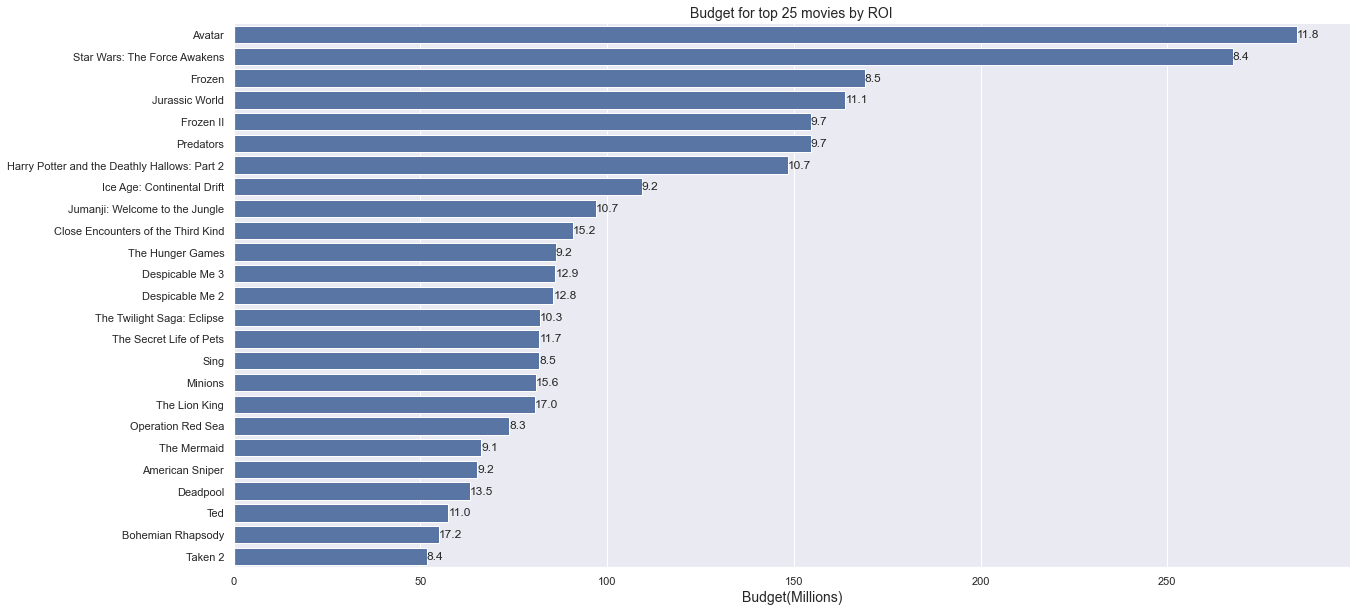

In [48]:
plt.figure(figsize=(20,10))
for i in top_25.index:
    roi = top_25.loc[i,'roi']
    y = top_25.loc[i,'budget']
    plt.annotate(roi, (y,i), ha='left',va='center',fontsize=12)

# top_25.budget = top_25.budget.apply(lambda x: x/1000000)
sns.barplot(data=top_25,
            x='budget',
            y='title',
           color='b')
plt.title('Budget for top 25 movies by ROI', fontsize=14)
plt.xlabel('Budget(Millions)',fontsize=14)
plt.ylabel('')
sns.despine()


In [21]:
top_25.head(5).budget.mean()

207.90400000000005

In [22]:
top_25.head(5).roi.mean()

9.9

In [23]:
top_25.iloc[6:].budget.mean()

81.22052631578947

In [24]:
top_25.iloc[6:].roi.mean()

11.605263157894735

The 5 most expensive movies average around $207MM for budget, but generated an average of 9.9X ROI, whereas the bottom 20 averaged $81MM but generated an average of 11.6X ROI. Therefore, one does not have to spend within the highest amounts in order to generate good returns. 

## (2b) What's the average budget for successful movies, by genre? 

In [25]:
# When looking at targeting a genre, we wanted to look at overall data to determine what genres are successful
# When looking at budget, we want to look at the most successful movies, not all of them 

# return original number of movies for one genre category. Some categories will not have 25 movies total  
def calculate_original_num_movies(df, genre):         
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)]
    return len(sub_df) 

# mean ROI for the top 25 movies 
def calculate_top_roi(df,genre):
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] 
    top_25 = sub_df.sort_values(by='roi',ascending=False).head(25)
    return top_25['roi'].mean() 

# mean budget for the top 25 movies (by ROI)
def calculate_top_budget(df, genre):
    # sort by ROI and then take the top 25 
    sub_df = df[df['genre_ids'].apply(lambda x: genre in x)] 
    top_25 = sub_df.sort_values(by='roi',ascending=False).head(25)
    return round((top_25['budget'].mean()/1000000),2)     

# return mean budget of the top 25 movies for each genre   
def budget_by_genre_df(df):
    output = tmdb_genres.copy() 
    output['original_num_movies'] = tmdb_genres.id.apply(lambda x: calculate_original_num_movies(df, x))
    output['avg_roi'] = tmdb_genres.id.apply(lambda x: calculate_top_roi(df, x))
    output['avg_budget_top_25'] = tmdb_genres.id.apply(lambda x: calculate_top_budget(df,x))
    output = output.sort_values(by="avg_budget_top_25", ascending=False)
    output = output[['genre','original_num_movies','avg_budget_top_25','avg_roi']]
    return output

In [26]:
successful_movies = budget_by_genre_df(q2)

Text(0.5, 1.0, 'Mean Budget for Top 25 Most Successful Movies by Genre')

<Figure size 432x288 with 0 Axes>

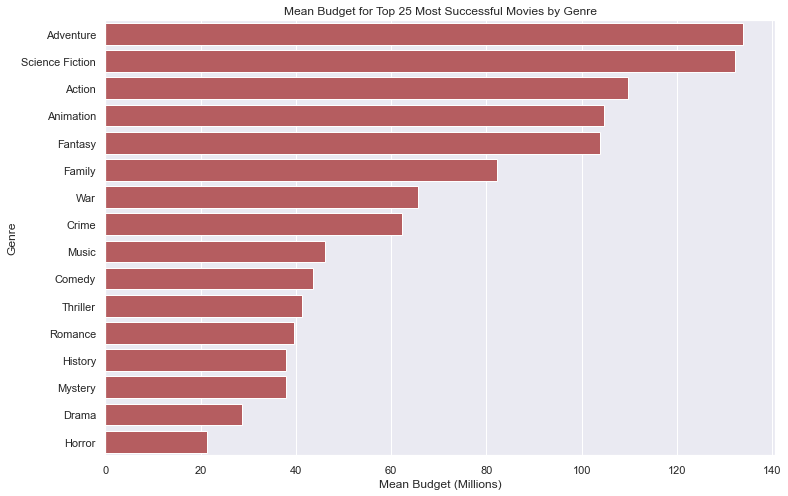

In [27]:
plt.clf()
data = successful_movies[successful_movies.original_num_movies >= 25].\
    sort_values(by='avg_budget_top_25',ascending=False) # only consider genres with at least 20 movies 
plt.figure(figsize=(12,8))
sns.set_palette("muted")
sns.barplot(x=data['avg_budget_top_25'],
            y=data['genre'],
            color='r')
plt.xlabel('Mean Budget (Millions)')
plt.ylabel('Genre')
plt.title('Mean Budget for Top 25 Most Successful Movies by Genre')


In [28]:
successful_movies[successful_movies.original_num_movies >= 25]

,genre,original_num_movies,avg_budget_top_25,avg_roi
1,Adventure,373,133.93,9.716
14,Science Fiction,211,132.12,9.404
0,Action,522,109.68,11.256
2,Animation,155,104.70,9.280
8,Fantasy,218,103.83,9.140
7,Family,223,82.14,10.308
17,War,59,65.57,5.392
4,Crime,214,62.21,7.172
11,Music,39,46.01,4.784
3,Comedy,518,43.54,14.136


| Clearly, budget needs to be adjusted depending on what type of movie is made. 

## (2c) Does spending more lead to better results? 
*Does a higher budget lead to more revenue, better ROI, higher popularity, and higher ratings?* 

In [29]:
# add the ratings column 
two_c = q2.merge(title_ratings[['tconst','avg_rating']],
             how='inner',
             left_on='imdb_id',
             right_on='tconst')

In [30]:
# TODO detect and remove outliers 
two_c


,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,revenue,budget,runtime,imdb_id,profits,roi,tconst,avg_rating
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,2.612408e+07,60720000.0,146,tt0926084,-3.459592e+07,0.4,tt0926084,7.7
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,1.614474e+08,202400000.0,98,tt0892769,-4.095260e+07,0.8,tt0892769,8.1
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,2.882339e+09,366756896.0,124,tt1228705,2.515582e+09,7.9,tt1228705,7.0
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,3.982816e+08,175136720.0,81,tt0114709,2.231449e+08,2.3,tt0114709,8.3
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,7.830661e+08,206043200.0,148,tt1375666,5.770229e+08,3.8,tt1375666,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,"[10752, 36, 18, 28]",508935,zh,八佰,15.572,2020-08-14,The Eight Hundred,7.3,54,4.664504e+08,80960000.0,147,tt7294150,3.854904e+08,5.8,tt7294150,7.0
1501,"[10752, 18]",442065,en,The Last Full Measure,14.567,2020-01-23,The Last Full Measure,7.7,248,3.404799e+06,20240000.0,110,tt0783640,-1.683520e+07,0.2,tt0783640,6.8
1502,"[28, 18]",628241,te,అల వైకుంఠపురములో,9.646,2020-01-12,Ala Vaikunthapurramuloo,6.4,42,2.920538e+07,14168000.0,165,tt9537292,1.503738e+07,2.1,tt9537292,7.1
1503,[28],581526,ko,다만 악에서 구하소서,9.585,2020-08-05,Deliver Us from Evil,6.9,38,3.507840e+07,12144000.0,108,tt12763920,2.293440e+07,2.9,tt12763920,6.8


In [31]:
data = two_c[two_c.revenue/1000000 < 3000] # remove outliers 
data['budget'].corr(data['revenue'])

0.7367453266936604

In [32]:
two_c['budget'].corr(two_c[two_c.vote_count > 10000]['avg_rating']) # only include movies with enough votes 

-0.0050978336561656405

In [33]:
data = two_c[two_c.popularity < 200] # remove outliers 
data['budget'].corr(data['popularity'])

0.2080426552853292

In [34]:
data = two_c[two_c.roi <=20] # remove outliers 
two_c['budget'].corr(two_c['roi'])

0.037701007162859776

***
* Budget and Revenue are correlated (.76) therefore spending more may lead to higher revenue. 
* Budget and ROI have a weak correlation (-.07) therefore spending more does not necessarily have an effect on returns. 
* Budget and popularity are positively correlated (.59), therefore spending more may lead to a higher popularity. 
* Budget and rating are weakly correlated (-.02), therefore spending more does not necessarily have an effect on the movie's rating.
***

In [35]:
# determine correlation between budget and a column, per genre 
# loop through all genres and create a dataframe based on correlation with another variable 
def budget_correlation(df, columns):
    genre_correlations = tmdb_genres.copy() 
    lengths = []
    # create the num_movies column 
    for genre in tmdb_genres.id.values:
        temp_df = df[df.genre_ids.apply(lambda x: genre in x)]
        df_len = len(temp_df) # number of movies in this genre 
        lengths.append(df_len)
        
    for column in columns:
        correlations = []
        # loop through each genre and make a sub df 
        for genre in tmdb_genres.id.values:
            temp_df = df[df.genre_ids.apply(lambda x: genre in x)]
            c = temp_df['budget'].corr(temp_df[column])
            correlations.append(c)

        correlations = pd.Series(correlations)
        genre_correlations['budget_corr_{col}'.format(col=column)] = correlations 
    genre_correlations['num_movies'] = lengths
    return genre_correlations

cols = ['revenue','roi','popularity','avg_rating']
revenue_correlations = budget_correlation(two_c, cols)
revenue_correlations[revenue_correlations.num_movies > 100]

,id,genre,budget_corr_revenue,budget_corr_roi,budget_corr_popularity,budget_corr_avg_rating,num_movies
0,28,Action,0.755238,0.156732,0.071587,0.279796,522
1,12,Adventure,0.701115,0.255647,0.058945,0.283884,373
2,16,Animation,0.649270,0.107669,0.094637,0.273506,155
3,35,Comedy,0.680101,-0.022999,0.165235,0.172689,518
4,80,Crime,0.755265,0.093115,0.168581,0.169426,214
6,18,Drama,0.623131,-0.021884,0.226161,0.105645,660
7,10751,Family,0.624032,0.044551,0.101458,0.295660,223
8,14,Fantasy,0.684007,0.094019,0.016925,0.252221,218
10,27,Horror,0.651018,-0.173120,0.050518,0.111332,119
12,9648,Mystery,0.652934,-0.104516,0.073582,0.228906,116


*** 
It seems that correlations are similar between budget and revenue, roi, popularity and rating, regardless of genre. 
***

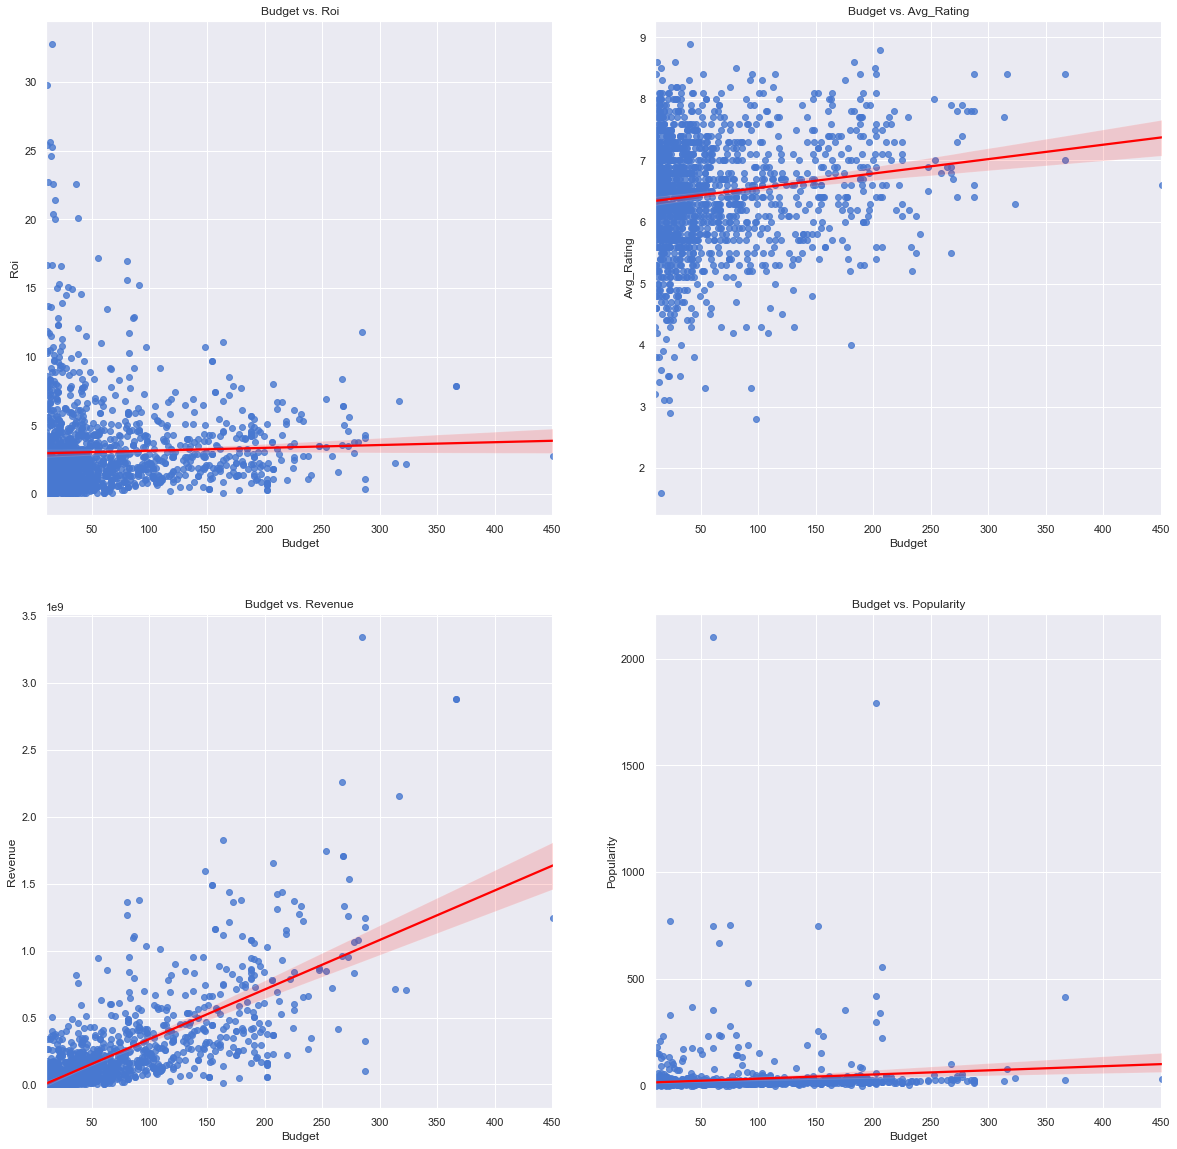

In [36]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,20))
axs_list = [item for sublist in axs for item in sublist]

lst = ['roi','avg_rating','revenue','popularity']
for col in lst: 
    ax = axs_list.pop(0)
    sns.regplot(x=two_c['budget']/1000000,y=two_c[col],ax=ax,line_kws={"color": "red"})
    ax.set_xlabel('Budget')
    ax.set_ylabel(col.title())
    ax.set_title('Budget vs. {column}'.format(column=col.title()))



Text(0.5, 1.0, 'Budget vs. Revenue')

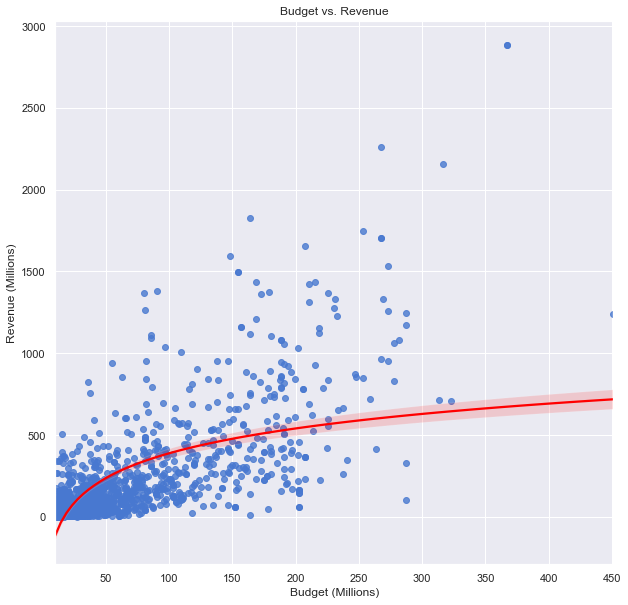

In [37]:
plt.figure(figsize=(10,10))
data = two_c[two_c.revenue/1000000 < 3000] # remove outliers 
sns.regplot(x=data['budget']/1000000,y=data['revenue']/1000000,logx=True,line_kws={"color": "red"})
plt.xlabel('Budget (Millions)')
plt.ylabel('Revenue (Millions)')
plt.title('Budget vs. Revenue')

Text(0.5, 1.0, 'Budget vs. Popularity')

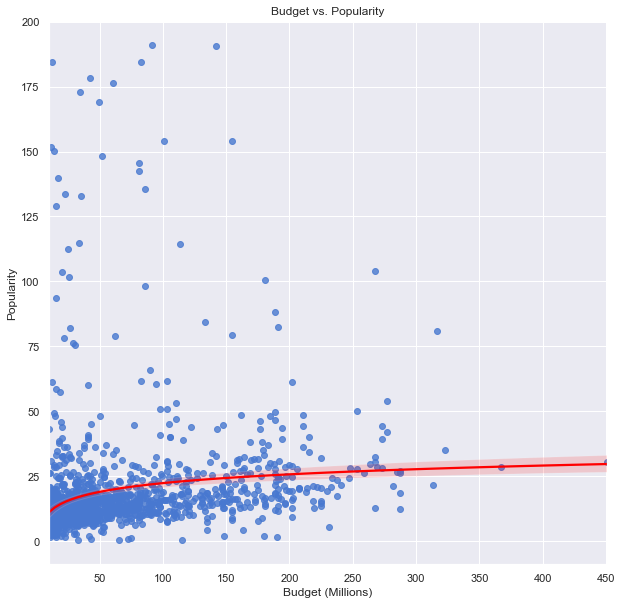

In [38]:
plt.figure(figsize=(10,10))
data = two_c[two_c.popularity < 200]
sns.regplot(x=data['budget']/1000000,y=data['popularity'],logx=True,line_kws={"color": "red"})
plt.xlabel('Budget (Millions)')
plt.ylabel('Popularity')
plt.title('Budget vs. Popularity')

Text(0.5, 1.0, 'Budget vs. ROI')

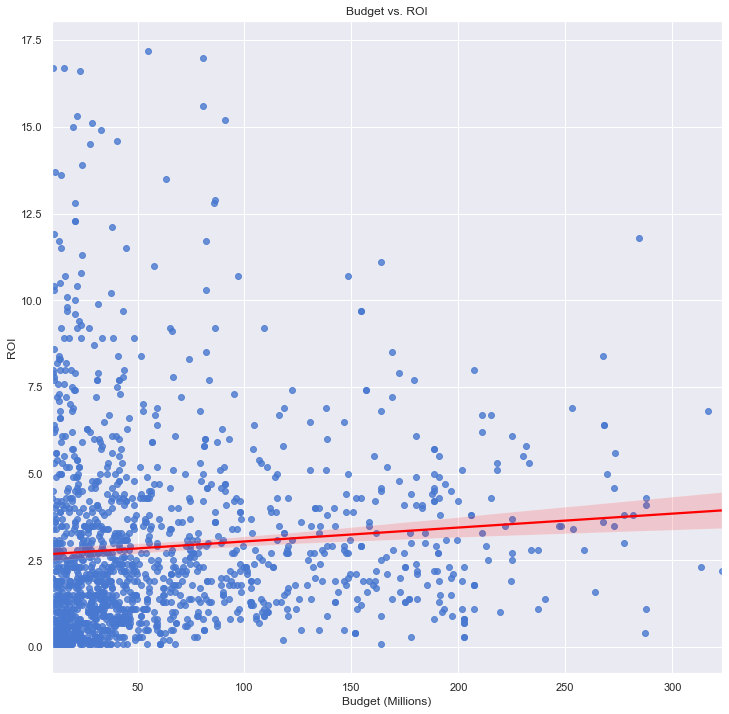

In [39]:
import numpy as np
test = two_c[two_c.roi < 20]
test = test[test.budget < 350000000]
plt.figure(figsize=(12,12))
sns.regplot(x=test['budget']/1000000,y=test['roi'],line_kws={"color": "red"})
plt.xlabel('Budget (Millions)')
plt.ylabel('ROI')
plt.title('Budget vs. ROI')

# Question 3: Who are the best actors, actresses and directors to recruit? 

In [40]:
# merge title_principals with ratings and basics 
# then merge with imdb_people 

title_ratings = pd.read_csv('zippedData/imdb/title.ratings.csv')
title_basics = pd.read_csv('zippedData/imdb/title.basics.csv')

principals_ratings = title_principals.merge(title_ratings.merge(title_basics,
                                                 how='inner',
                                                 on='tconst'))
principals_ratings_people = principals_ratings.merge(imdb_people[['nconst','primary_name']],
                                                     how='inner',
                                                     on='nconst') 

q3 = principals_ratings_people[['tconst','primary_title','averagerating',
                                'numvotes','start_year','genres','runtime_minutes',
                                'nconst','primary_name','category']]
q3 = q3.rename(columns={'averagerating':'title_rating'})

# convert genres column to list 
q3 = q3.dropna(subset=['genres'])
q3.genres = q3.genres.apply(lambda x: x.split(','))


In [41]:
def remove_duplicate_genres(genre_list):
    final = []
    for genre in genre_list:
        if genre in final:
            continue
        else:
            final.append(genre)
    return final
#     return [final.append(genre) for genre in genre_list if genre not in final]


def rating_by_category(df,categories):
    # get a sub df of all rows for selected categories 
    category_df = df[df['category'].apply(lambda x: x in categories)]
    
    # get the number of movies each individual was in 
    num_movies = category_df.groupby('nconst').tconst.count().reset_index()
    # rename column and sort values by the number of movies 
    num_movies = num_movies.rename(columns={'tconst':'num_movies'})

    # get the average rating of the movies each actor was in asda
    avg_rating = category_df.groupby('nconst').title_rating.mean().reset_index()
    avg_rating.rename(columns={'title_rating':'mean_rating'},inplace=True)
    
    # get the total votes 
    # get the total numvotes for the actor 
    total_votes = category_df.groupby('nconst').numvotes.sum().reset_index()
    total_votes.rename(columns={'numvotes':'sum_votes'},inplace=True)

    # combine the genres for all movies the actor is in 
    genres = category_df.groupby('nconst').genres.sum().reset_index()
    combined = num_movies.merge(avg_rating.merge(total_votes.merge(genres,
                                                                    how = 'inner',
                                                                    on = 'nconst')))
    final = combined.merge(category_df[['nconst','primary_name','category']],
                             how='inner',
                             on='nconst')
    final = final.drop_duplicates(subset=['nconst']) 
    final.genres = final.genres.apply(lambda x: remove_duplicate_genres(x))
    final.sort_values(by='mean_rating',ascending=False,inplace=True)
    return final[['primary_name','mean_rating','sum_votes','num_movies','genres','category']]  

## (3a) Who are the best individuals to recruit by rating?  

#### Who are the top 10 most popular actors by rating?
*Popular actors have at least 100,000 votes and are in at least two movies* 

In [42]:
actors = rating_by_category(q3,['actor','actress'])
top_actors = actors[(actors.num_movies > 1) & (actors.sum_votes > 1000000)]
top_actors.head(10)

,primary_name,mean_rating,sum_votes,num_movies,genres,category
338,Leonardo DiCaprio,8.090000,6273640,10,"[Drama, Romance, Mystery, Thriller, Biography,...",actor
1911,Robert Downey Jr.,7.530769,6356093,13,"[Action, Adventure, Sci-Fi, Crime, Drama, Come...",actor
100174,Andrew Garfield,7.472727,2123693,11,"[Action, Adventure, Sci-Fi, Drama, Romance, Bi...",actor
8805,Ian McKellen,7.412500,2402777,8,"[Adventure, Family, Fantasy, Comedy, Action, S...",actor
32707,Tom Hardy,7.361538,4943284,13,"[Crime, Drama, Action, Adventure, Sci-Fi, Spor...",actor
53302,Mark Ruffalo,7.323529,4832689,17,"[Crime, Drama, Biography, Sport, Comedy, Roman...",actor
27380,Chris Evans,7.300000,5508196,16,"[Action, Drama, Sci-Fi, Biography, Crime, Adve...",actor
90516,Carey Mulligan,7.272727,1597020,11,"[Drama, Romance, Sci-Fi, Music, Crime, War, Bi...",actress
135154,Mackenzie Foy,7.214286,1385200,7,"[Drama, Adventure, Animation, Comedy, Sci-Fi, ...",actress
16,Brad Pitt,7.208333,2819089,12,"[Action, Animation, Comedy, Crime, Thriller, B...",actor


Leonardo DiCaprio seems to be the safest bet, with the highest average rating. 

### Who are the top 10 most underrated actors/actresses? 
*Underrated actors have between 100,000 and 1,000,000 votes and are in at least 5 movies* 

In [63]:
# underrated actors: actors in at least 5 movies, and have anywhere between 100,000 and 1,000,000 votes
underrated_actors = actors[(actors.num_movies > 5) & (actors.sum_votes < 1000000) & (actors.sum_votes > 500000)]
underrated_actors[underrated_actors.genres.apply(lambda x: all(item in x for item in ['Adventure','Sci-Fi']))].head(10) #only sci-fi,adventure directors

,primary_name,mean_rating,sum_votes,num_movies,genres,category
63949,Mahershala Ali,7.466667,779328,6,"[Action, Biography, Drama, Adventure, Sci-Fi, ...",actor
20987,Min-sik Choi,7.033333,533562,9,"[Action, Crime, Drama, Adventure, Animation, H...",actor
3792,Robin Wright,7.014286,954254,7,"[Crime, Drama, Thriller, Romance, Action, Adve...",actress
6145,Joaquin Phoenix,6.990909,902297,11,"[Drama, Comedy, Crime, Music, Romance, Sci-Fi,...",actor
3146,Robert Redford,6.976923,916369,13,"[Documentary, Action, Adventure, Sci-Fi, Drama...",actor
57789,Tilda Swinton,6.876923,577553,13,"[Action, Drama, Sci-Fi, Documentary, Fantasy, ...",actress
101870,Riz Ahmed,6.800000,804726,8,"[Crime, Drama, Thriller, Comedy, Action, Sci-F...",actor
22368,Marion Cotillard,6.741176,592171,17,"[Action, Crime, Drama, Romance, Adventure, Sci...",actress
62441,Jeffrey Wright,6.718182,658269,11,"[Crime, Drama, Thriller, Action, Sci-Fi, Adven...",actor
78629,Adil Hussain,6.695833,618191,24,"[Action, Adventure, Thriller, Drama, Comedy, F...",actor


Derek Jacobi can be a good choice for a lesser known actor. He has been in 10 movies, with an average rating of 7.78. 

### Who are the top 10 directors by rating? 

In [44]:
directors = rating_by_category(q3,['director'])
top_directors = directors[(directors.num_movies > 1) & (directors.sum_votes > 1000000)]
top_directors.head(10)

,primary_name,mean_rating,sum_votes,num_movies,genres,category
65,Quentin Tarantino,8.675000,1655377,4,"[Drama, Western, Crime, Mystery, Action, Thril...",director
12825,Christopher Nolan,8.425000,4994749,4,"[Action, Adventure, Sci-Fi, Thriller, Drama, H...",director
14834,Joe Russo,8.225000,2361820,4,"[Action, Adventure, Sci-Fi]",director
14828,Anthony Russo,8.225000,2361820,4,"[Action, Adventure, Sci-Fi]",director
46375,Damien Chazelle,7.966667,1172995,3,"[Biography, Drama, History, Comedy, Music]",director
1457,Wes Anderson,7.933333,1033599,3,"[Adventure, Comedy, Drama, Crime, Animation]",director
372,Peter Jackson,7.875000,1739425,4,"[Adventure, Family, Fantasy, Documentary, Hist...",director
106,David Fincher,7.866667,1717750,3,"[Crime, Drama, Mystery, Biography, Thriller]",director
17772,Denis Villeneuve,7.800000,2013951,6,"[Mystery, Thriller, Crime, Drama, War, Sci-Fi,...",director
6912,Alejandro G. Iñárritu,7.733333,1220992,3,"[Drama, Romance, Action, Adventure, Biography,...",director


### Who are the top 10 most underrated directors? 
*Underrated directors have between 100,000 and 1,000,000 votes and have directed more than 1 movie* 

In [62]:
underrated_directors = directors[(directors.num_movies > 1) & (directors.sum_votes < 1000000) & (directors.sum_votes > 500000)]
underrated_directors[underrated_directors.genres.apply(lambda x: all(item in x for item in ['Adventure','Sci-Fi']))].head(10) #only sci-fi,adventure directors

,primary_name,mean_rating,sum_votes,num_movies,genres,category
47906,Ryan Coogler,7.466667,809006,3,"[Action, Adventure, Sci-Fi, Biography, Drama, ...",director
6486,Alex Garland,7.300000,653206,2,"[Drama, Mystery, Sci-Fi, Adventure, Horror]",director
41275,Joseph Kosinski,7.166667,795659,3,"[Action, Adventure, Fantasy, Sci-Fi, Biography...",director
10563,Justin Lin,7.166667,886483,3,"[Action, Crime, Thriller, Adventure, Sci-Fi]",director
800,George Miller,7.000000,819306,2,"[Adventure, Animation, Comedy, Action, Sci-Fi]",director
21973,Neil Burger,6.933333,916362,3,"[Comedy, Drama, Mystery, Sci-Fi, Thriller, Act...",director
17129,Guillermo del Toro,6.900000,871066,3,"[Action, Adventure, Sci-Fi, Drama, Fantasy, Ho...",director
21701,Colin Trevorrow,6.866667,670883,3,"[Action, Adventure, Sci-Fi, Comedy, Drama, Rom...",director
37145,Gareth Edwards,6.866667,913611,3,"[Drama, Sci-Fi, Thriller, Action, Adventure]",director
255,Peter Berg,6.780000,729352,5,"[Action, Drama, History, Biography, Adventure,...",director


*** 
Consider Lee Unkrich who, with almost 1MM votes and the higest rating, seems popular and well regarded by critics.
***

## (3b) Who are the best individuals to recruit by gross revenue?  

In [52]:
def earnings_by_category(df,categories):
    # get a sub df of all rows for selected categories 
    category_df = df[df['category'].apply(lambda x: x in categories)]
    category_df = category_df.merge(tmdb_movies[['revenue','budget','imdb_id']],
                                   how='inner',
                                   left_on='tconst',
                                   right_on='imdb_id')
    # get the number of movies each individual was in 
    num_movies = category_df.groupby('nconst').tconst.count().reset_index()
    num_movies = num_movies.rename(columns={'tconst':'num_movies'}) # rename column and sort values by the number of movies 
    
    # sum all the genres for the movies a person is in 
    genres = category_df.groupby('nconst').genres.sum().reset_index()
    
    # get the revenue and budget 
    gross = category_df.groupby('nconst')['revenue'].sum().reset_index()
    budget = category_df.groupby('nconst')['budget'].sum().reset_index()
    median_budget = category_df.groupby('nconst')['budget'].median().reset_index()
    median_budget.rename(columns={'budget':'median_budget'},inplace=True)
    
    combined = num_movies.merge(genres.merge(median_budget.merge(gross.merge(budget,
                                                                 how='inner',
                                                                 on='nconst'))))
                                
    # combine stats with the original category dataframe  
    final = combined.merge(category_df[['nconst','primary_name','category']],
                                      how='left',
                                      on='nconst')
    # clean up 
    final = final.drop_duplicates(subset=['nconst'])                            
    final.genres = final.genres.apply(lambda x: remove_duplicate_genres(x)) # remove the duplicate genres
    
    # add the total ROI columns 
    final['total_roi'] = round((final['revenue'] / final['budget']),1)
    # round columns 
    final.revenue = final.revenue.apply(lambda x: round(x/1000000000,1))
    final.budget = final.budget.apply(lambda x: round(x/1000000000,1))
    final.median_budget = final.median_budget.apply(lambda x: round(x/1000000,1))
        
    final.sort_values(by='revenue',ascending=False,inplace=True)
    return final[['primary_name','revenue','budget','median_budget','total_roi','num_movies','genres']]  # remove category 



### Who are the top 10 actors by gross revenue? 

In [50]:
top_grossing_actors = earnings_by_category(q3,['actor','actress']).head(10)

In [51]:
top_grossing_actors

,primary_name,revenue,budget,median_budget,total_roi,num_movies,genres
1625,Robert Downey Jr.,12.3,2.2,200000000.0,5.6,13,"[Action, Adventure, Sci-Fi, Crime, Drama, Come..."
11998,Chris Evans,10.2,1.8,32100000.0,5.7,16,"[Action, Drama, Sci-Fi, Biography, Crime, Adve..."
26079,Chris Hemsworth,9.1,2.0,115000000.0,4.5,15,"[Action, Biography, Drama, Adventure, Sci-Fi, ..."
14814,Dwayne Johnson,8.7,1.9,95000000.0,4.6,20,"[Action, Comedy, Crime, Thriller, Drama, Famil..."
20066,Mark Ruffalo,8.3,1.4,22000000.0,5.9,16,"[Comedy, Drama, Music, Crime, Mystery, Thrille..."
5870,Vin Diesel,6.4,1.3,160000000.0,4.9,9,"[Action, Crime, Thriller, Adventure, Comedy, S..."
19202,Chris Pratt,6.0,1.2,90000000.0,5.2,13,"[Comedy, Romance, Drama, Thriller, Action, Adv..."
5558,Anne Hathaway,5.4,1.3,43500000.0,4.3,18,"[Action, Comedy, Crime, Drama, History, Musica..."
35775,Jennifer Lawrence,5.3,1.4,64500000.0,3.9,18,"[Crime, Drama, Horror, Mystery, Action, Advent..."
288,Johnny Depp,5.0,2.1,135000000.0,2.3,15,"[Action, Adventure, Western, Family, Fantasy, ..."


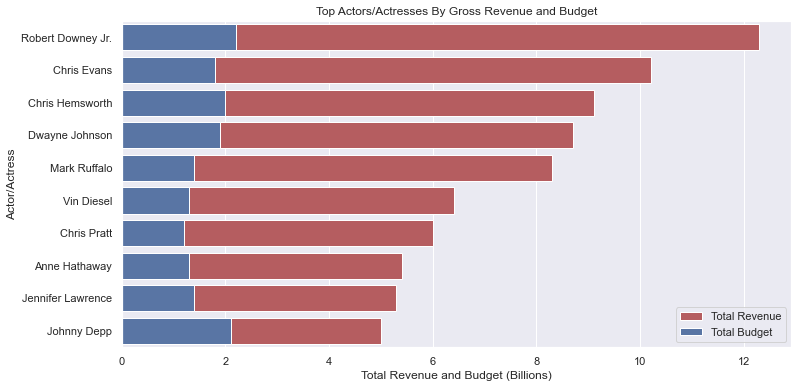

In [55]:
# TODO annotate ROIs 

data = top_grossing_actors 
plt.figure(figsize=(12,6))

sns.barplot(x=data['revenue'],
                y=data['primary_name'], 
                color='r',label='Total Revenue')
sns.barplot(x=data['budget'],
                y=data['primary_name'], 
                color='b',label='Total Budget')

plt.xlabel('Total Revenue and Budget (Billions)')
plt.ylabel('Actor/Actress')
plt.title('Top Actors/Actresses By Gross Revenue and Budget')
plt.legend()


### Who are the top 10 directors by gross revenue? 

In [53]:
top_grossing_directors = earnings_by_category(q3,['director']).head(10)
# top_grossing_directors = top_grossing_directors[['primary_name','revenue','num_movies','genres']]
# top_grossing_directors.revenue = top_grossing_directors.revenue.apply(lambda x: round(x/1000000000,1))
# top_grossing_directors.rename(columns={'primary_name':'Name','revenue':'Revenue (Billions)'},inplace=True)
top_grossing_directors

,primary_name,revenue,budget,median_budget,total_roi,num_movies,genres
5445,Anthony Russo,6.7,1.1,275.0,6.2,4,"[Action, Adventure, Sci-Fi]"
5449,Joe Russo,6.7,1.1,275.0,6.2,4,"[Action, Adventure, Sci-Fi]"
6681,David Yates,4.1,0.9,180.0,4.4,5,"[Action, Adventure, Drama, Fantasy, Mystery, F..."
9309,James Wan,3.4,0.4,26.5,8.3,6,"[Horror, Mystery, Thriller, Action, Adventure,..."
4804,Christopher Nolan,3.1,0.7,162.5,4.6,4,"[Action, Adventure, Sci-Fi, Thriller, Drama, H..."
192,Michael Bay,3.0,0.7,195.0,4.3,5,"[Action, Adventure, Sci-Fi, Comedy, Crime, Dra..."
293,Peter Jackson,3.0,0.8,250.0,3.9,4,"[Adventure, Family, Fantasy, Documentary, Hist..."
6550,Joss Whedon,2.9,0.5,220.0,6.2,3,"[Comedy, Drama, Romance, Action, Adventure, Sc..."
5282,Chris Renaud,2.9,0.4,75.0,7.8,5,"[Adventure, Animation, Comedy, Family]"
715,J.J. Abrams,2.8,0.5,190.0,5.8,3,"[Mystery, Sci-Fi, Thriller, Action, Adventure,..."


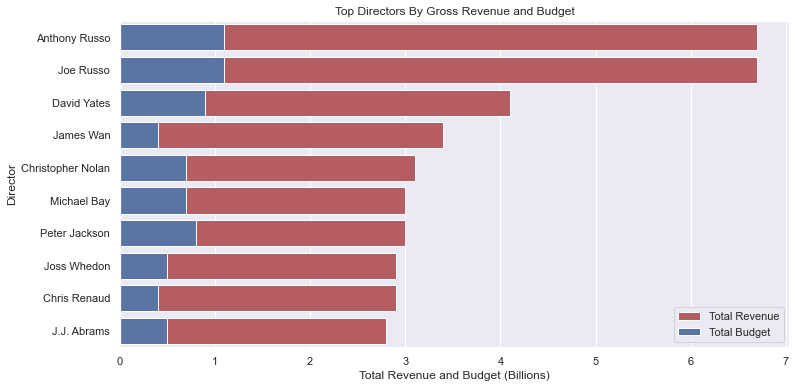

In [54]:
data = top_grossing_directors 
plt.figure(figsize=(12,6))

sns.barplot(x=data['revenue'],
                y=data['primary_name'], 
                color='r',label='Total Revenue')
sns.barplot(x=data['budget'],
                y=data['primary_name'], 
                color='b',label='Total Budget')

plt.xlabel('Total Revenue and Budget (Billions)')
plt.ylabel('Director')
plt.title('Top Directors By Gross Revenue and Budget')
plt.legend()

# Question 4: When should the movie be released? 

In [ ]:
# clean up movie_budgets data
movie_budgets.release_date = movie_budgets.release_date.apply(lambda x: datetime.strptime(x.replace(',',''), '%b %d %Y')) 
movie_budgets['release_month'] = movie_budgets['release_date'].apply(lambda x: int(x.month))
movie_budgets.worldwide_gross = movie_budgets.worldwide_gross.apply(lambda x: float(x.strip('$').replace(',','')))
movie_budgets.production_budget = movie_budgets.production_budget.apply(lambda x: float(x.strip('$').replace(',','')))
movie_budgets.rename(columns={'production_budget':'budget','worldwide_gross':'revenue'},inplace=True)


In [ ]:
# adjust numbers to be in 2020 dollars 
q4 = adjust_inflation(movie_budgets)

In [ ]:
q4

### Get the average revenue of a movie, by month

In [ ]:
avg_revenue = q4.groupby('release_month').revenue.mean().reset_index().sort_values(by='revenue',ascending=False)
avg_revenue.revenue = avg_revenue.revenue/1000000

months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
avg_revenue['month_names'] = avg_revenue['release_month'].apply(lambda x: months[x])

plt.figure(figsize=(12,8))
sns.barplot(data=avg_revenue,
            x='month_names',
            y='revenue',
            color='r')
plt.xlabel('Month')
plt.ylabel('Revenue (Millions)')
plt.title('Average Revenue By Month')
